In [1]:
from IPython.display import Image
%matplotlib inline

## PyTorch Geometric 라이브러리를 사용한 GNN 구현


In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn


from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np

In [4]:
dset = QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [5]:
# 데이터셋의 첫 번째 데이터를 불러옵니다.
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [6]:
# data.z는 데이터셋의 첫 번째 데이터에 있는 원자의 원자 번호를 나타냅니다.
data.z

tensor([6, 1, 1, 1, 1])

In [7]:
# data 객체에 새로운 속성을 추가합니다. 여기서는 임의로 [1, 2, 3] 텐서를 추가합니다.
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

x=[5, 11]: 각 노드의 특성(feature)을 나타내는 행렬입니다. 여기서 5는 노드의 개수, 11은 각 노드에 대한 특성의 수를 의미합니다.

edge_index=[2, 8]: 그래프의 에지(엣지)를 나타내는 인덱스 행렬입니다. 2는 두 노드 사이의 연결을 나타내며, 8은 총 에지의 수를 의미합니다.

edge_attr=[8, 4]: 에지의 특성을 나타내는 행렬입니다. 8은 에지의 개수, 4는 각 에지에 대한 특성의 수를 의미합니다.

y=[1, 19]: 타겟 변수 또는 레이블을 나타내는 행렬입니다. 1은 레이블의 차원, 19는 다양한 물리적, 화학적 성질을 나타내는 레이블의 수입니다.

pos=[5, 3]: 각 노드의 위치 정보를 나타내는 행렬입니다. 5는 노드의 개수, 3은 공간 좌표(3차원)를 의미합니다.

idx=[1]: 데이터의 고유 식별자 또는 인덱스를 나타냅니다.

name='gdb_1': 데이터의 이름 또는 식별자입니다.

z=[5]: 원자 번호를 나타내는 배열입니다. 5는 데이터에 포함된 원자의 개수를 의미합니다.

new_attribute=[3]: 사용자가 임의로 추가한 새로운 속성입니다. [1, 2, 3] 텐서가 이 속성으로 추가되었습니다.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda

True

In [9]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [10]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [11]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
for total_epochs in range(epochs):

    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()

    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs


    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.53 | validation avg. loss: 0.19
Epochs: 1 | epoch avg. loss: 0.13 | validation avg. loss: 0.07
Epochs: 2 | epoch avg. loss: 0.10 | validation avg. loss: 0.06
Epochs: 3 | epoch avg. loss: 0.10 | validation avg. loss: 0.12


In [14]:
net.eval()
predictions = []
real = []

for batch in testloader:

    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

Text(0.5, 0, 'Isotropic polarizability')

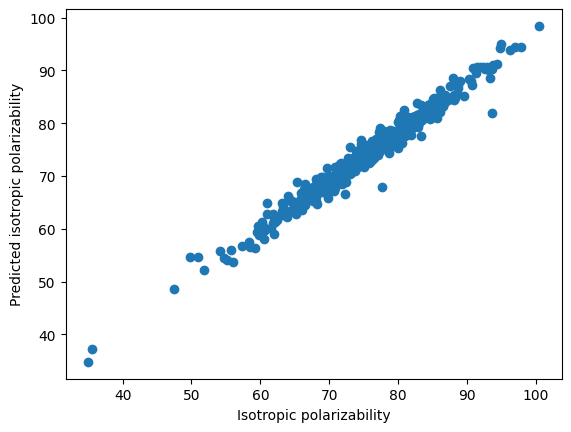

In [15]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
#plt.savefig('figures/18_12.png', dpi=300)